
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい


In [20]:
import geopandas as gpd
import pandas as pd

# GeoJSONファイルの読み込み
geo_data = gpd.read_file('13-tokyo-all.geojson')

# 収入データと国勢調査の小地域集計データ
directory = 'Data' # ディレクトリのパス

age_data_path = f'{directory}/h27_age_df.csv'
family_data_path = f'{directory}/h27_family_df.csv'
gender_data_path = f'{directory}/h27_gender_df2.csv'
housing_data_path = f'{directory}/h27_house_df.csv'
house_info_data_path = f'{directory}/h27_house_info_df.csv'
industry_data_path = f'{directory}/h27_indusry_df.csv'
occupation_data_path = f'{directory}/h27_job_df.csv'
labor_data_path = f'{directory}/h27_labor_df.csv'
marriage_data_path = f'{directory}/h27_marriage_df.csv'
employment_status_data_path = f'{directory}/h27_work_status_df.csv'
income_data_path = f'{directory}/income_district.csv'

age_data = pd.read_csv(age_data_path) #年齢層別人口、性別別人口などに関するデータ
family_data = pd.read_csv(family_data_path) #家族に関するデータ 
gender_data = pd.read_csv(gender_data_path) #総人口、男女別人口などに関するデータ
housing_data = pd.read_csv(housing_data_path) #住宅関連データ
house_info_data = pd.read_csv(house_info_data_path) #住居の階数別データ
industry_data = pd.read_csv(industry_data_path) #職業別男女人口データ
occupation_data = pd.read_csv(occupation_data_path) #職業別男女人口データ（職業分類が異なる）
labor_data = pd.read_csv(labor_data_path) #労働状況データ
marriage_data = pd.read_csv(marriage_data_path) #結婚状況データ
employment_status_data = pd.read_csv(employment_status_data_path) #就業形態データ
income_data = pd.read_csv(income_data_path) #地域コードと平均収入


# 全てのマージ
merged_data = pd.merge(age_data, family_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, gender_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, housing_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, house_info_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, industry_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, occupation_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, labor_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, marriage_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, employment_status_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])

merged_data = pd.merge(
    merged_data,
    income_data[['area_code', 'income_mean']],
    left_on='district_id',  # 'merged_data'のキー
    right_on='area_code',   # 'income_data'のキー
    how='left'
)

# 'area_code'列内のNaNを含む行を削除する
merged_data = merged_data.dropna(subset=['area_code'])

# 'area_code'を整数型に変換
merged_data['area_code'] = merged_data['area_code'].astype(int)

# 一致しない'district_id'がある行を削除する
merged_data = merged_data.dropna(subset=['income_mean'])

def fill_na_with_mode(df, group_col, target_col):
    # 各グループ内で最頻値を計算する
    mode_values = df.groupby(group_col)[target_col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
    
    # 最頻値でNaNを置き換える
    df[target_col] = df.apply(
        lambda row: mode_values[row[group_col]] if pd.isna(row[target_col]) else row[target_col],
        axis=1
    )
    return df

# 'district2_id'と'district2_name'内のNaNを同じ'district_id'内の最頻値で置き換える
merged_data = fill_na_with_mode(merged_data, 'district_id', 'district2_id')
merged_data = fill_na_with_mode(merged_data, 'district_id', 'district2_name')


def fill_na_with_first_valid(df, group_col, target_col):
    # 各グループ内で最初の非NaN値を取得する
    first_valid_values = df.groupby(group_col)[target_col].first()
    
    # 最初の非NaN値でNaNを置き換える
    df[target_col] = df.apply(
        lambda row: first_valid_values[row[group_col]] if pd.isna(row[target_col]) else row[target_col],
        axis=1
    )
    return df

# 'district_name'内のNaNを同じ'district_id'内の最初の非NaN値で置き換える
merged_data = fill_na_with_first_valid(merged_data, 'district_id', 'district_name')

# 結果を確認する
merged_data.head()

,district_id,district2_id,level_identifier,state_name,city_name,district_name,district2_name,10-14,15-19,20-24,...,employer_male,self_employed_male,family_work_male,unkonwn_status_male,employer_female,self_employed_female,family_work_female,unkonwn_status_female,area_code,income_mean
0,45201,10.0,1,宮崎県,宮崎市,橘通西,１丁目,19220,20777,17510,...,80219,13952,1541,2791,76534,3968,6097,2127,45201,410.041038
1,45201,10.0,2,宮崎県,宮崎市,橘通西,１丁目,32,56,61,...,198,42,9,24,206,36,17,20,45201,410.041038
2,45201,1001.0,3,宮崎県,宮崎市,橘通西,１丁目,9,6,11,...,31,14,2,6,35,19,2,3,45201,410.041038
3,45201,1002.0,3,宮崎県,宮崎市,橘通西,２丁目,2,10,18,...,29,15,6,7,34,7,9,9,45201,410.041038
4,45201,1003.0,3,宮崎県,宮崎市,橘通西,３丁目,-,1,-,...,3,2,-,-,3,-,2,-,45201,410.041038


In [21]:
# データの前処理
# 数値型の列に対して '-' やその他の無効なデータを NaN に変換
for column in merged_data.columns:
    merged_data[column] = pd.to_numeric(merged_data[column], errors='coerce')

# 欠損値を処理（例えば、中央値で埋める）
merged_data.fillna(merged_data.median(), inplace=True)

Mean Squared Error: 2865.41
R^2 Score: 0.12


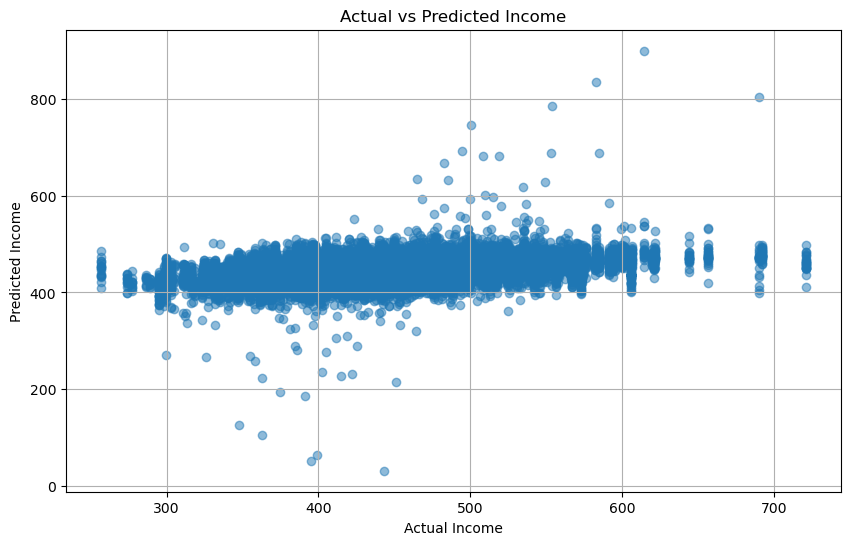

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# カテゴリカルデータをエンコーディングする

merged_data_encoded = pd.get_dummies(merged_data, columns=['state_name', 'city_name', 'district_name', 'district2_name'])# ワンホットエンコーディング

# 特徴量とターゲットの分離
X = merged_data_encoded.drop(['income_mean'], axis=1)
y = merged_data_encoded['income_mean']

# データのスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# モデルのトレーニング
model = LinearRegression()
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_test)

# モデルの評価
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# 予測結果の可視化
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Income')
plt.ylabel('Predicted Income')
plt.title('Actual vs Predicted Income')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# ディレクトリのパス
directory = 'Data'

# 各CSVファイルのパスを組み合わせてフルパスを作成
age_data_path = f'{directory}/h27_age_df.csv'
family_data_path = f'{directory}/h27_family_df.csv'
gender_data_path = f'{directory}/h27_gender_df2.csv'
housing_data_path = f'{directory}/h27_house_df.csv'
house_info_data_path = f'{directory}/h27_house_info_df.csv'
industry_data_path = f'{directory}/h27_indusry_df.csv'
occupation_data_path = f'{directory}/h27_job_df.csv'
labor_data_path = f'{directory}/h27_labor_df.csv'
marriage_data_path = f'{directory}/h27_marriage_df.csv'
employment_status_data_path = f'{directory}/h27_work_status_df.csv'
income_data_path = f'{directory}/income_district.csv'

# CSVファイルを読み込む
age_data = pd.read_csv(age_data_path)
family_data = pd.read_csv(family_data_path)
gender_data = pd.read_csv(gender_data_path)
housing_data = pd.read_csv(housing_data_path)
house_info_data = pd.read_csv(house_info_data_path)
industry_data = pd.read_csv(industry_data_path)
occupation_data = pd.read_csv(occupation_data_path)
labor_data = pd.read_csv(labor_data_path)
marriage_data = pd.read_csv(marriage_data_path)
employment_status_data = pd.read_csv(employment_status_data_path)
income_data = pd.read_csv(income_data_path)

# データの結合（例として全てのデータを結合する）
merged_data = pd.merge(age_data, family_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, gender_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, housing_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, house_info_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, industry_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, occupation_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, labor_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, marriage_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, employment_status_data, on=['district_id', 'district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
merged_data = pd.merge(merged_data, income_data, on=['district_id'])

# データの前処理
# 数値型の列に対して '-' やその他の無効なデータを NaN に変換
for column in merged_data.columns:
    merged_data[column] = pd.to_numeric(merged_data[column], errors='coerce')

# 欠損値を処理（例えば、中央値で埋める）
merged_data.fillna(merged_data.median(), inplace=True)

# カテゴリカルデータをエンコーディングする
# ラベルエンコーディング
label_encoder = LabelEncoder()

for column in ['state_name', 'city_name', 'district_name', 'district2_name']:
    if column in merged_data.columns:
        merged_data[column + '_encoded'] = label_encoder.fit_transform(merged_data[column].astype(str))

# ワンホットエンコーディング
merged_data_encoded = pd.get_dummies(merged_data, columns=['state_name', 'city_name', 'district_name', 'district2_name'])

# 特徴量とターゲットの分離
X = merged_data_encoded.drop(['income_mean'], axis=1)
y = merged_data_encoded['income_mean']

# データのスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# モデルのトレーニング
model = LinearRegression()
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_test)

# モデルの評価
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# 予測結果の可視化
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Income')
plt.ylabel('Predicted Income')
plt.title('Actual vs Predicted Income')
plt.grid(True)
plt.show()
